# WeatherWise: Intelligent Weather Analysis & Advisory System
### Harnessing Python and AI to Create Intuitive Weather Applications

This notebook implements a comprehensive weather analysis system with:
- Weather data retrieval
- Natural language processing
- Data visualization
- Interactive user interface
"""

In [1]:
!pip install fetch-my-weather pyinputplus matplotlib spacy
!python -m spacy download en_core_web_sm

import requests
import json
import matplotlib.pyplot as plt
import pyinputplus as pyip
import spacy
from datetime import datetime
import os
from typing import Dict, List, Optional, Union

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Weather API configuration
WEATHER_API_URL = "https://wttr.in/{location}?format=j1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Weather Data Functions
Core functions for retrieving and processing weather data

In [2]:
def get_weather_data(location: str, forecast_days: int = 5) -> Optional[Dict]:
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
        None: If data retrieval fails
    """
    try:
        response = requests.get(WEATHER_API_URL.format(location=location))
        response.raise_for_status()
        data = response.json()

        # Process current conditions
        current = {
            'temp_c': data['current_condition'][0]['temp_C'],
            'feelslike_c': data['current_condition'][0]['FeelsLikeC'],
            'humidity': data['current_condition'][0]['humidity'],
            'weather_desc': data['current_condition'][0]['weatherDesc'][0]['value'],
            'wind_speed': data['current_condition'][0]['windspeedKmph'],
            'precip': data['current_condition'][0]['precipMM']
        }

        # Process forecast data
        forecast = []
        for day in data['weather'][:forecast_days]:
            forecast.append({
                'date': day['date'],
                'maxtemp_c': day['maxtempC'],
                'mintemp_c': day['mintempC'],
                'avgtemp_c': day['avgtempC'],
                'sunrise': day['astronomy'][0]['sunrise'],
                'sunset': day['astronomy'][0]['sunset'],
                'hourly': [{
                    'time': hour['time'],
                    'temp_c': hour['tempC'],
                    'weather_desc': hour['weatherDesc'][0]['value'],
                    'precip': hour['precipMM'],
                    'humidity': hour['humidity']
                } for hour in day['hourly']]
            })

        return {
            'location': location,
            'current': current,
            'forecast': forecast
        }

    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

In [3]:
def validate_weather_data(data: Dict) -> bool:
    """
    Validate the structure and content of weather data.

    Args:
        data (dict): Weather data to validate

    Returns:
        bool: True if data is valid, False otherwise
    """
    required_keys = ['location', 'current', 'forecast']
    if not all(key in data for key in required_keys):
        return False

    current_required = ['temp_c', 'feelslike_c', 'weather_desc']
    if not all(key in data['current'] for key in current_required):
        return False

    if not isinstance(data['forecast'], list) or len(data['forecast']) == 0:
        return False

    return True

## Natural Language Processing Functions
Functions for understanding and responding to weather questions

In [4]:
def parse_weather_question(question: str) -> Dict:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    doc = nlp(question.lower())

    # Initialize result structure
    result = {
        'location': None,
        'timeframe': 'current',  # default to current conditions
        'attributes': [],
        'question_type': None,
        'day_index': 0  # default to today
    }

    # Common weather attributes to look for
    weather_attributes = {
        'temperature': ['temp', 'temperature', 'hot', 'cold', 'warm', 'cool'],
        'precipitation': ['rain', 'snow', 'precip', 'drizzle', 'shower'],
        'humidity': ['humid', 'humidity', 'moist'],
        'wind': ['wind', 'breeze', 'gust'],
        'sun': ['sun', 'sunny', 'sunshine'],
        'general': ['weather', 'forecast', 'outlook']
    }

    # Extract location (proper nouns)
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            result['location'] = ent.text.title()  # Convert to title case
            break

    # Detect timeframe
    time_indicators = {
        'today': ('today', 'now', 'current'),
        'tomorrow': ('tomorrow', 'day after'),
        'week': ('week', 'weekly')
    }

    for token in doc:
        for timeframe, keywords in time_indicators.items():
            if token.text in keywords:
                result['timeframe'] = 'forecast' if timeframe in ['tomorrow', 'week'] else 'current'
                if timeframe == 'tomorrow':
                    result['day_index'] = 1
                break

    # Detect weather attributes
    for token in doc:
        for attr, keywords in weather_attributes.items():
            if token.text in keywords and attr not in result['attributes']:
                result['attributes'].append(attr)
                break  # Stop checking other attributes once found

    # If no attributes found but question contains "weather", use general
    if not result['attributes'] and any(token.text in ['weather', 'forecast'] for token in doc):
        result['attributes'].append('general')

    # Determine question type based on timeframe
    result['question_type'] = result['timeframe']

    return result

In [5]:
def generate_weather_response(parsed_question: Dict, weather_data: Dict) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    if not validate_weather_data(weather_data):
        return "Sorry, I'm having trouble accessing weather data right now."

    location = parsed_question.get('location', weather_data['location'])
    timeframe = parsed_question['timeframe']
    attributes = parsed_question['attributes'] or ['general']  # Default to general if no attributes

    # Build response for specific attributes
    response_parts = []

    if timeframe == 'current':
        current = weather_data['current']
        response_parts.append(f"Current weather in {location}:")

        if 'general' in attributes:
            response_parts.extend([
                f"Condition: {current['weather_desc']}",
                f"Temperature: {current['temp_c']}°C (feels like {current['feelslike_c']}°C)",
                f"Humidity: {current['humidity']}%",
                f"Wind: {current['wind_speed']} km/h",
                f"Precipitation: {current['precip']} mm"
            ])
        else:
            for attr in attributes:
                if attr == 'temperature':
                    response_parts.append(f"Temperature: {current['temp_c']}°C (feels like {current['feelslike_c']}°C)")
                elif attr == 'precipitation':
                    response_parts.append(f"Precipitation: {current['precip']} mm")
                elif attr == 'humidity':
                    response_parts.append(f"Humidity: {current['humidity']}%")
                elif attr == 'wind':
                    response_parts.append(f"Wind speed: {current['wind_speed']} km/h")
                elif attr == 'sun':
                    response_parts.append(f"Conditions: {current['weather_desc']}")

    else:  # forecast
        day_index = parsed_question.get('day_index', 0)
        forecast_day = weather_data['forecast'][day_index]
        date_str = forecast_day['date']

        day_label = "Today" if day_index == 0 else ("Tomorrow" if day_index == 1 else date_str)
        response_parts.append(f"Weather forecast for {location} on {day_label}:")

        if 'general' in attributes:
            response_parts.extend([
                f"Condition: {forecast_day['hourly'][0]['weather_desc']}",
                f"Temperature: High {forecast_day['maxtemp_c']}°C, Low {forecast_day['mintemp_c']}°C",
                f"Sunrise: {forecast_day['sunrise']}, Sunset: {forecast_day['sunset']}",
                f"Precipitation: {max(float(hour['precip']) for hour in forecast_day['hourly'])} mm"
            ])
        else:
            for attr in attributes:
                if attr == 'temperature':
                    response_parts.append(
                        f"Temperature: High {forecast_day['maxtemp_c']}°C, "
                        f"Low {forecast_day['mintemp_c']}°C, "
                        f"Avg {forecast_day['avgtemp_c']}°C"
                    )
                elif attr == 'precipitation':
                    max_precip = max(float(hour['precip']) for hour in forecast_day['hourly'])
                    response_parts.append(f"Expected max precipitation: {max_precip} mm")
                elif attr == 'humidity':
                    avg_humidity = sum(float(hour['humidity']) for hour in forecast_day['hourly']) / len(forecast_day['hourly'])
                    response_parts.append(f"Average humidity: {avg_humidity:.1f}%")
                elif attr == 'sun':
                    response_parts.append(
                        f"Sunrise at {forecast_day['sunrise']}, Sunset at {forecast_day['sunset']}"
                    )

    return "\n".join(response_parts)

In [6]:
def show_visualizations(weather_data: Dict) -> None:
    """Display available visualizations."""
    print("\nAvailable Visualizations:")
    choice = pyip.inputMenu(
        ['Temperature Trends', 'Precipitation Forecast', 'Both', 'Back'],
        numbered=True
    )

    if choice == 'Temperature Trends':
        create_temperature_visualization(weather_data)
    elif choice == 'Precipitation Forecast':
        create_precipitation_visualization(weather_data)
    elif choice == 'Both':
        create_temperature_visualization(weather_data)
        create_precipitation_visualization(weather_data)

In [7]:
def create_temperature_visualization(weather_data: Dict, output_type: str = 'display') -> Optional[plt.Figure]:
    """
    Create visualization of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualization in the notebook
    """
    if not validate_weather_data(weather_data):
        print("Invalid weather data for visualization")
        return None

    forecast = weather_data['forecast']
    dates = [day['date'] for day in forecast]
    max_temps = [float(day['maxtemp_c']) for day in forecast]
    min_temps = [float(day['mintemp_c']) for day in forecast]
    avg_temps = [float(day['avgtemp_c']) for day in forecast]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(dates, max_temps, 'r-', label='Max Temp (°C)', marker='o')
    ax.plot(dates, min_temps, 'b-', label='Min Temp (°C)', marker='o')
    ax.plot(dates, avg_temps, 'g--', label='Avg Temp (°C)', marker='x')

    ax.set_title(f"Temperature Forecast for {weather_data['location']}")
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)

    if output_type == 'figure':
        return fig
    plt.show()

In [8]:
def create_precipitation_visualization(weather_data: Dict, output_type: str = 'display') -> Optional[plt.Figure]:
    """
    Create visualization of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualization in the notebook
    """
    if not validate_weather_data(weather_data):
        print("Invalid weather data for visualization")
        return None

    forecast = weather_data['forecast']
    dates = [day['date'] for day in forecast]

    # Calculate total precipitation for each day
    daily_precip = []
    for day in forecast:
        total = sum(float(hour['precip']) for hour in day['hourly'])
        daily_precip.append(total)

    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(dates, daily_precip, color='blue', alpha=0.7)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f} mm',
                ha='center', va='bottom')

    ax.set_title(f"Precipitation Forecast for {weather_data['location']}")
    ax.set_ylabel('Precipitation (mm)')
    plt.xticks(rotation=45)
    ax.grid(True, axis='y')

    if output_type == 'figure':
        return fig
    plt.show()

In [9]:
def display_current_weather(weather_data: Dict) -> None:
    """Display current weather conditions."""
    if not validate_weather_data(weather_data):
        print("Unable to display current weather: invalid data")
        return

    current = weather_data['current']
    location = weather_data['location']

    print("\n" + "="*50)
    print(f"Current Weather in {location}")
    print("="*50)
    print(f"Condition: {current['weather_desc']}")
    print(f"Temperature: {current['temp_c']}°C (Feels like {current['feelslike_c']}°C)")
    print(f"Humidity: {current['humidity']}%")
    print(f"Wind: {current['wind_speed']} km/h")
    print(f"Precipitation: {current['precip']} mm")
    print("="*50 + "\n")

def display_forecast(weather_data: Dict) -> None:
    """Display weather forecast."""
    if not validate_weather_data(weather_data):
        print("Unable to display forecast: invalid data")
        return

    forecast = weather_data['forecast']
    location = weather_data['location']

    print("\n" + "="*50)
    print(f"Weather Forecast for {location}")
    print("="*50)

    for i, day in enumerate(forecast):
        day_label = "Today" if i == 0 else ("Tomorrow" if i == 1 else day['date'])
        print(f"\n{day_label}:")
        print(f"- Condition: {day['hourly'][0]['weather_desc']}")
        print(f"- Temperature: High {day['maxtemp_c']}°C, Low {day['mintemp_c']}°C")
        print(f"- Sunrise: {day['sunrise']}, Sunset: {day['sunset']}")

    print("\n" + "="*50 + "\n")

In [10]:
def handle_weather_question(weather_data: Dict, question: str = None) -> None:
    """Handle natural language weather questions."""
    if question is None:
        print("\nYou can ask questions like:")
        print("- What's the weather in London tomorrow?")
        print("- Will it rain in Paris today?")
        print("- How windy is it in New York?")
        question = pyip.inputStr("\nEnter your weather question: ")

    parsed = parse_weather_question(question)
    print("Parsed question:", parsed)  # Debug output

    if not parsed['location']:
        parsed['location'] = weather_data['location']

    # Get fresh data if location changed
    if parsed['location'].lower() != weather_data['location'].lower():
        new_data = get_weather_data(parsed['location'])
        if new_data:
            weather_data = new_data
        else:
            print(f"Couldn't get data for {parsed['location']}, using previous location")

    response = generate_weather_response(parsed, weather_data)
    print("\n" + "="*50)
    print("WeatherWise Response:")
    print(response)
    print("="*50 + "\n")

    # Show relevant visualization if applicable
    if 'temperature' in parsed['attributes']:
        create_temperature_visualization(weather_data)
    elif 'precipitation' in parsed['attributes']:
        create_precipitation_visualization(weather_data)

In [11]:
def main_menu() -> Dict:
    """Main application menu."""
    print("\n" + "="*50)
    print("WeatherWise: Intelligent Weather Analysis")
    print("="*50)

    # Get initial location
    location = pyip.inputStr("Enter a location (e.g., London, New York): ")
    weather_data = get_weather_data(location)

    if not weather_data:
        print("Failed to get initial weather data. Using default location.")
        weather_data = get_weather_data("London")

    while True:
        print("\nMain Menu:")
        choice = pyip.inputMenu(
            ['Current Weather', 'Forecast', 'Ask Question', 'Visualizations', 'Change Location', 'Exit'],
            numbered=True
        )

        if choice == 'Current Weather':
            display_current_weather(weather_data)
        elif choice == 'Forecast':
            display_forecast(weather_data)
        elif choice == 'Ask Question':
            handle_weather_question(weather_data)
        elif choice == 'Visualizations':
            show_visualizations(weather_data)
        elif choice == 'Change Location':
            new_loc = pyip.inputStr("Enter new location: ")
            new_data = get_weather_data(new_loc)
            if new_data:
                weather_data = new_data
                print(f"Weather data updated for {new_loc}")
            else:
                print("Failed to get data for new location")
        else:
            print("Thank you for using WeatherWise!")
            return weather_data

Starting WeatherWise...

WeatherWise: Intelligent Weather Analysis
Enter a location (e.g., London, New York): dhaka

Main Menu:
Please select one of the following:
1. Current Weather
2. Forecast
3. Ask Question
4. Visualizations
5. Change Location
6. Exit
4

Available Visualizations:
Please select one of the following:
1. Temperature Trends
2. Precipitation Forecast
3. Both
4. Back
3


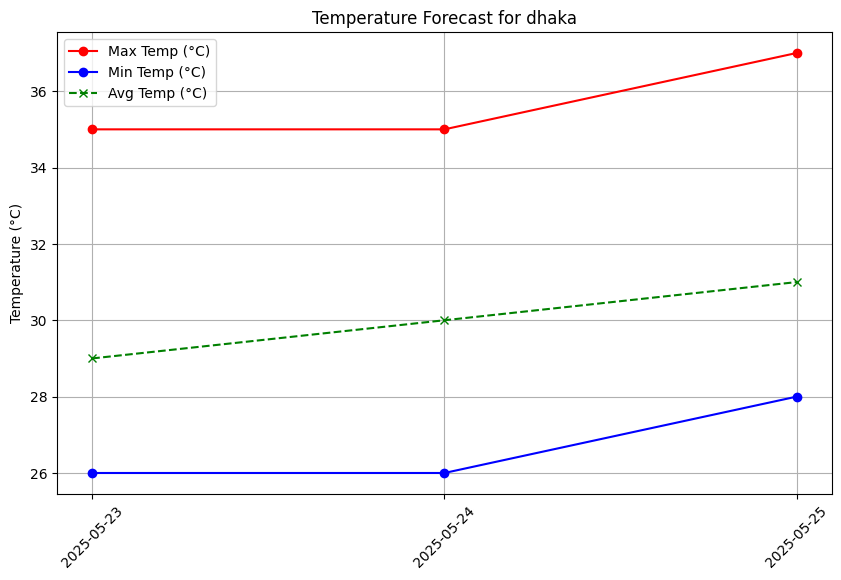

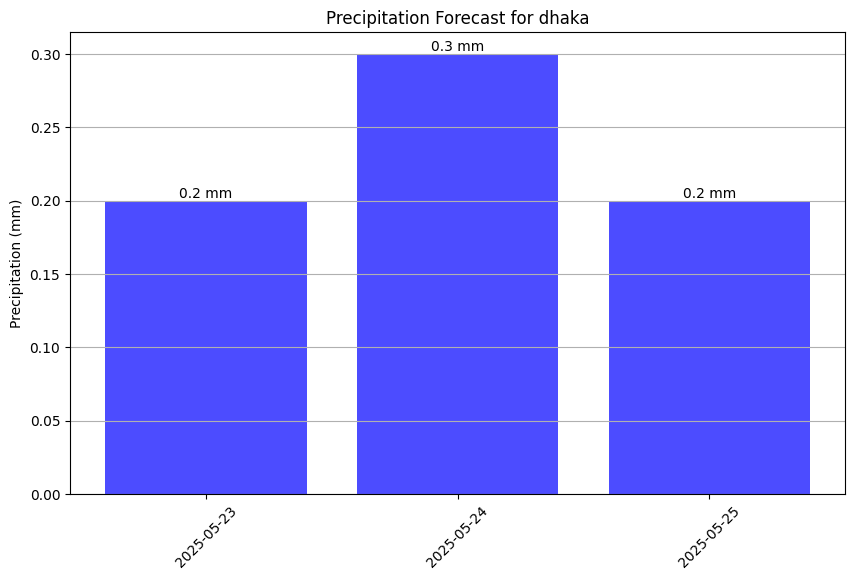


Main Menu:
Please select one of the following:
1. Current Weather
2. Forecast
3. Ask Question
4. Visualizations
5. Change Location
6. Exit
6
Thank you for using WeatherWise!
Session ended. Final weather data was for: dhaka


In [12]:
if __name__ == "__main__":
    print("Starting WeatherWise...")
    final_weather_data = main_menu()
    print("Session ended. Final weather data was for:", final_weather_data.get('location', 'Unknown'))